# Integrating data using ingest and BBKNN

<div class="alert alert-info">

**Note**
    
The following tutorial describes [BBKNN](https://github.com/Teichlab/bbknn) [[Polanski19]](https://10.1093/bioinformatics/btz625), which integrates well with the Scanpy workflow and is accessible through [`bbknn`](https://scanpy.readthedocs.io/en/stable/external/scanpy.external.pp.bbknn.html) and a simple PCA-based method for integrating data we call [`ingest`](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html). The latter assumes one has an annotated reference dataset that essentially captures the relevant biological variability and is well-embedded already. The rational then is to fit a model (here and for the time being, a PCA) on the reference data and to use it to project new data. As the model is simple and the procedure clear, the workflow is transparent and fast. Like BBKNN, it leaves the data matrix invariant. Unlike BBKNN, it solves the label mapping problem and maintains an embedding that might have desired properties - like displaying clear trajectories.  Similar PCA-based integrations have been used in many papers before, for instance, in [Weinreb18](https://doi.org/10.1101/467886).

We refer to this *asymmetric* dataset integration as *ingesting* annotations from an annotated reference `adata_ref` into an `adata` that still lacks this annotation. This is different from learning a joint representation that integrates datasets in a symmetric way as [BBKNN](https://github.com/Teichlab/bbknn), MNN, Scanorma, Conos, CCA (e.g. in Seurat) or a conditional VAE (e.g. in scVI, trVAE) would do. Take a look at tools in the [external API](https://scanpy.readthedocs.io/en/latest/external/#data-integration) or at the [ecoystem page](https://scanpy.readthedocs.io/en/latest/ecosystem/#data-integration) to get a start with other tools.
<div>

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False)

/Users/alexwolf/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


scanpy==1.4.5.dev225+g87e3537 anndata==0.7rc2.dev9+g5928e64 umap==0.3.8 numpy==1.16.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


## PBMCs

We consider an annotated reference dataset `adata_ref` and a dataset for which you want to query labels and embeddings `adata`.

In [4]:
adata_ref = sc.datasets.pbmc3k_processed()  # this is an earlier version of the dataset from the pbmc3k tutorial
adata = sc.datasets.pbmc68k_reduced()

To use `sc.tl.ingest`, the datasets need to be defined on the same variables.

In [5]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

The model and graph (here PCA, neighbors, UMAP) trained on the reference data will explain the biological variation observed within it.

In [6]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The manifold still looks essentially the same as in the [clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

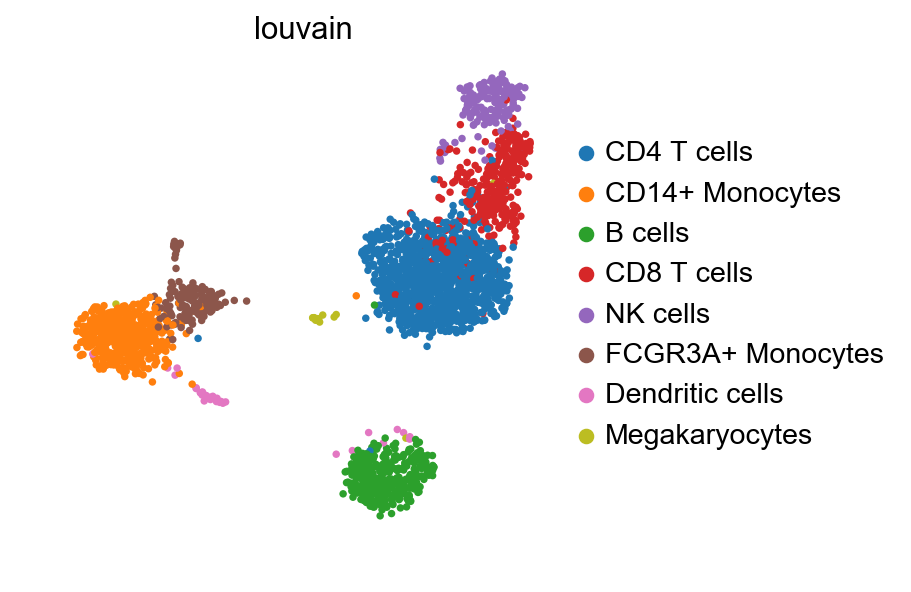

In [7]:
sc.pl.umap(adata_ref, color='louvain')

### Mapping PBMCs using ingest

Let's map labels and embeddings from `adata_ref` to `adata` based on a chosen representation. Here, we use `adata_ref.obsm['X_pca']` to map cluster labels and the UMAP coordinates.

In [8]:
sc.tl.ingest(adata, adata_ref, obs='louvain')

In [9]:
adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors

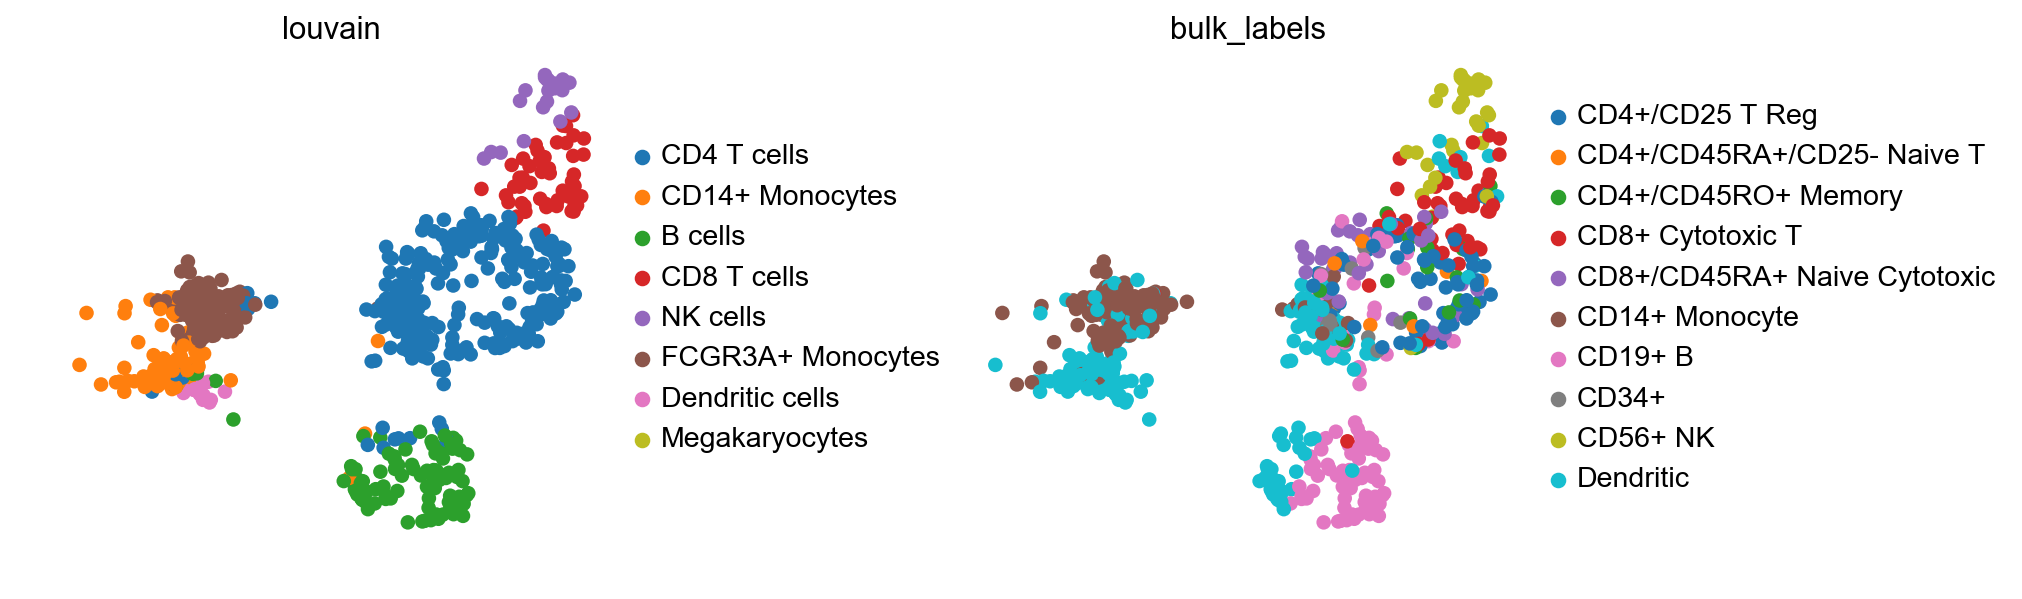

In [10]:
sc.pl.umap(adata, color=['louvain', 'bulk_labels'], wspace=0.5)

By comparing the 'bulk_labels' annotation with 'louvain', we see that the data has been reasonably mapped, only the annotation of dendritic cells seems ambiguous and might have been ambiiguous in `adata` already.

In [11]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])

In [12]:
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix category colors

... storing 'bulk_labels' as categorical
... storing 'phase' as categorical


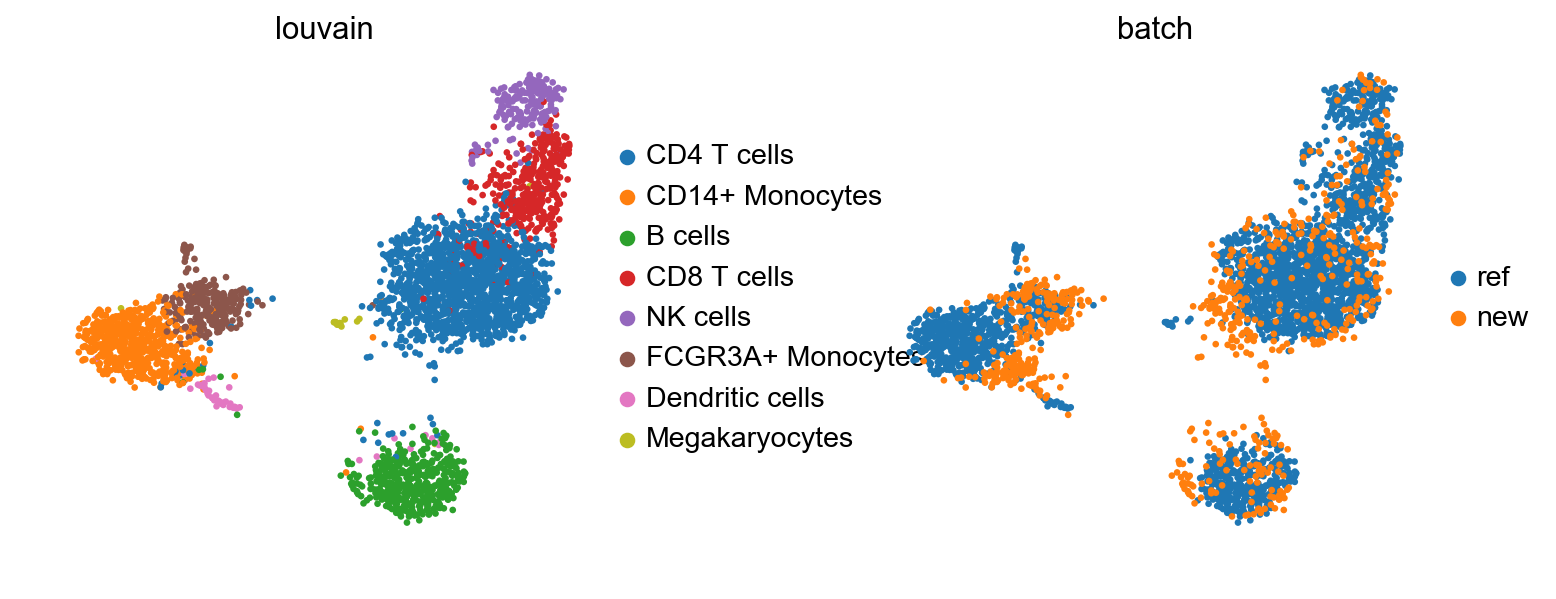

In [13]:
sc.pl.umap(adata_concat, color=['louvain', 'batch'], wspace=0.4)

While there seems to be some batch-effect in the monocytes and dendritic cell clusters, the new data is otherwise mapped relatively homogeneously.

The megakaryoctes are only present in `adata_ref` and no cells from `adata` map onto them. If interchanging reference data and query data, Megakaryocytes do not appear as a separate cluster anymore. This is an extreme case as the reference data is very small; but one should always question if the reference data contain enough biological variation to meaningfully accomodate query data.

### Using BBKNN

In [14]:
sc.tl.pca(adata_concat)

In [15]:
%%time
sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6

CPU times: user 3.57 s, sys: 552 ms, total: 4.12 s
Wall time: 3.64 s


In [16]:
sc.tl.umap(adata_concat)

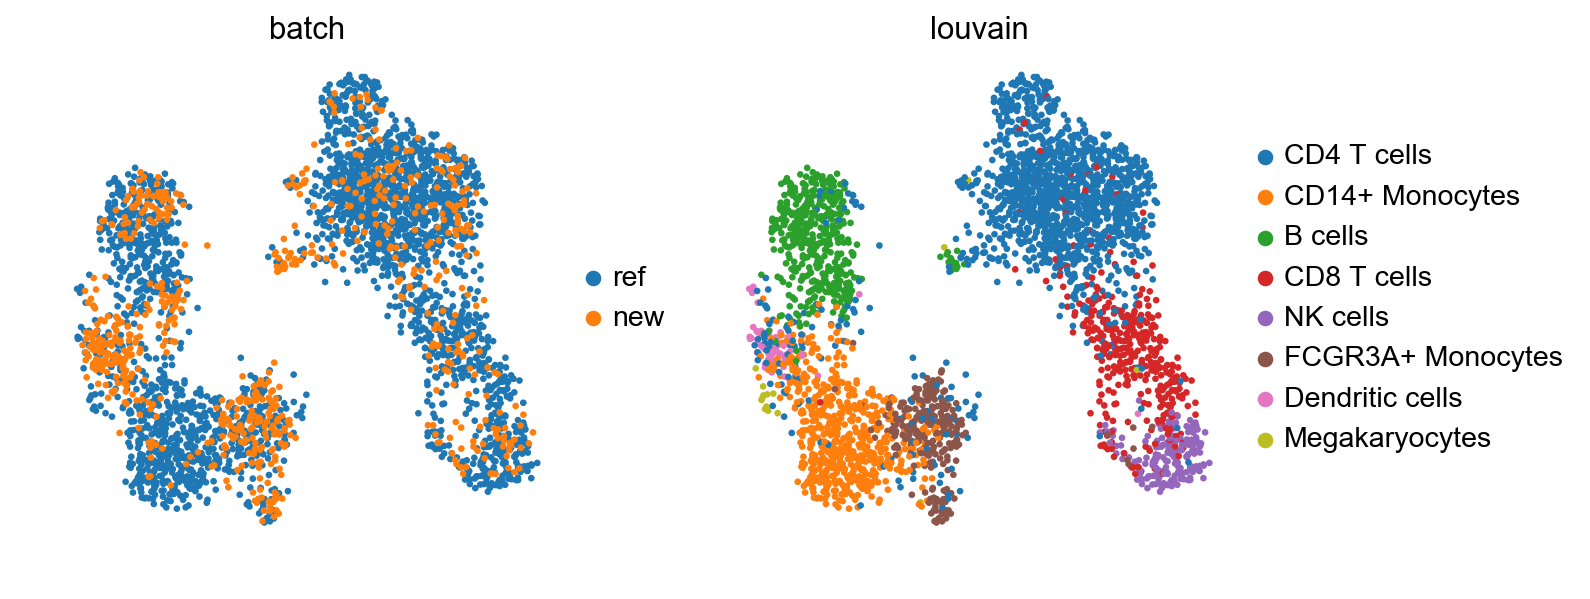

In [17]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

Also BBKNN doesn't maintain the Megakaryocytes cluster. However, it seems to mix cells more homogeneously.

## Pancreas

The following data has been used in the scGen paper [(Lotfollahi *et al.*, 2019)](https://doi.org/10.1038/s41592-019-0494-8), has been used [here](https://nbviewer.jupyter.org/github/M0hammadL/scGen_notebooks/blob/master/notebooks/scgen_batch_removal.ipynb), was curated [here](https://nbviewer.jupyter.org/github/Teichlab/bbknn/blob/master/examples/pancreas.ipynb) and can be downloaded from [here (the BBKNN paper)](ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip).

It contains data for human pancreas from 4 different studies (Segerstolpe16, Baron16, Wang16, Muraro16), which have been used in the seminal papers on single-cell dataset integration (Butler18, Haghverdi18) and many times ever since.

In [18]:
# note that this collection of batches is already intersected on the genes
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

In [19]:
adata_all.shape

(14693, 2448)

Inspect the cell types observed in these studies.

In [20]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

To simplify visualization, let's remove the 5 minority classes.

In [21]:
minority_classes = counts.index[-5:].tolist()        # get the minority classes
adata_all = adata_all[                               # actually subset
    ~adata_all.obs.celltype.isin(minority_classes)]
adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance 
    counts.index[:-5].tolist(), inplace=True)  

### Seeing the batch effect

In [22]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

We observe a batch effect.

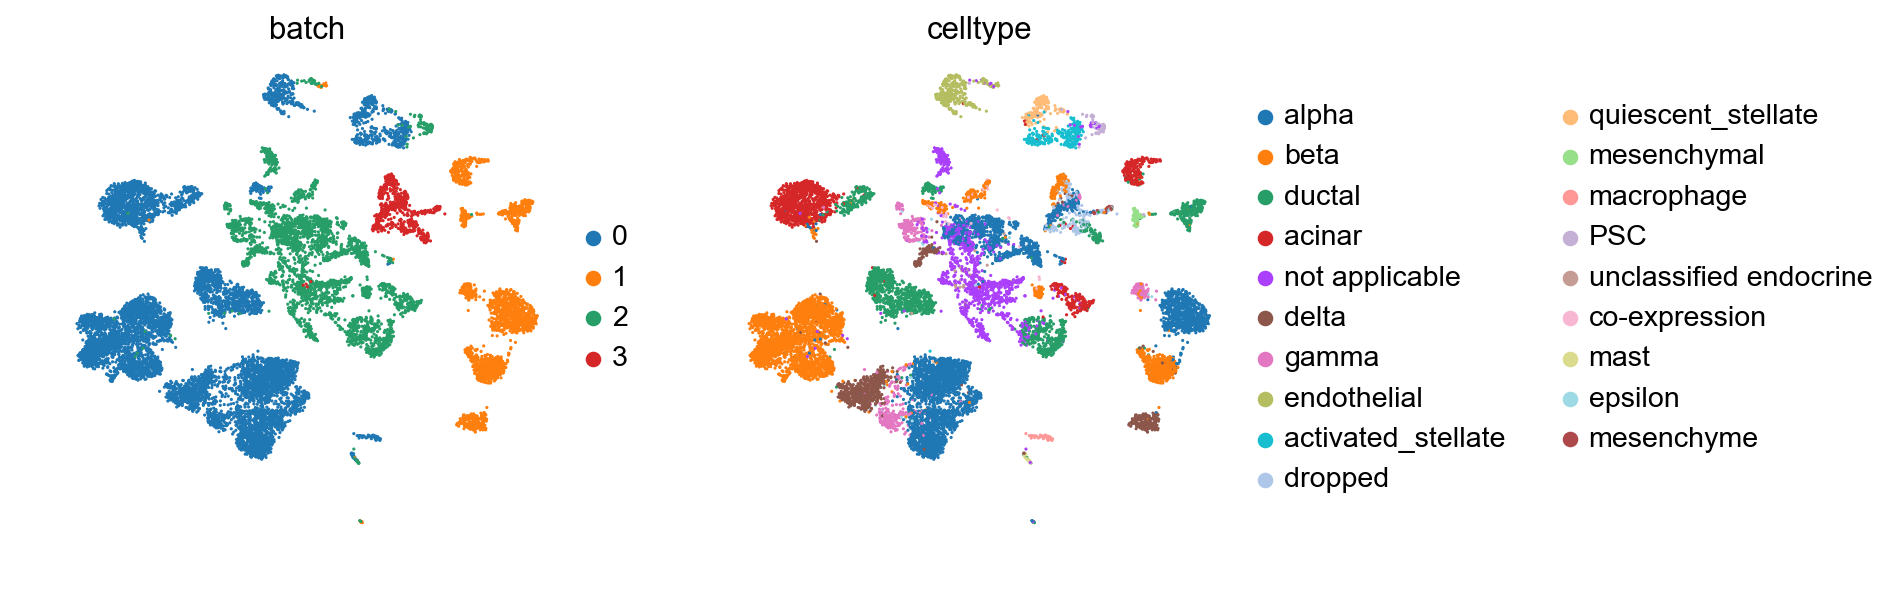

In [23]:
sc.pl.umap(adata_all, color=['batch', 'celltype'], palette=sc.pl.palettes.vega_20_scanpy)

### BBKNN

It can be well-resolved using [BBKNN](https://github.com/Teichlab/bbknn) [[Polanski19]](https://10.1093/bioinformatics/btz625).

In [24]:
%%time
sc.external.pp.bbknn(adata_all, batch_key='batch')

CPU times: user 2.23 s, sys: 1.68 s, total: 3.91 s
Wall time: 2.53 s


In [25]:
sc.tl.umap(adata_all)

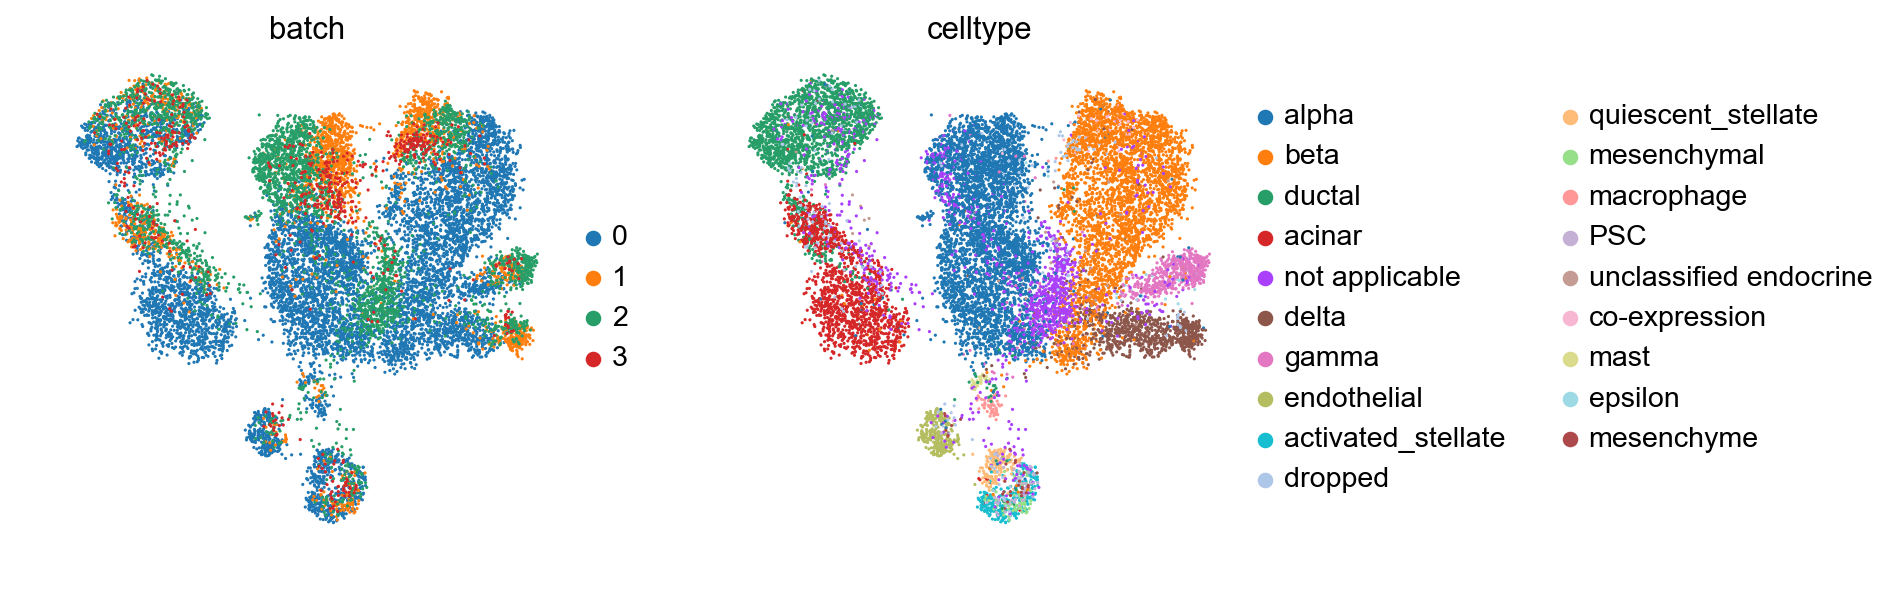

In [26]:
sc.pl.umap(adata_all, color=['batch', 'celltype'])

If one prefers to work more iteratively starting from one reference dataset, one can use ingest.

### Mapping onto a reference batch using ingest

Choose one reference batch for training the model and setting up the neighborhood graph (here, a PCA) and separate out all other batches.

As before, the model trained on the reference batch will explain the biological variation observed within it.

In [27]:
adata_ref = adata_all[adata_all.obs.batch == '0']

Compute the PCA, neighbors and UMAP on the reference data.

In [28]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The reference batch contains 12 of the 19 cell types across all batches.

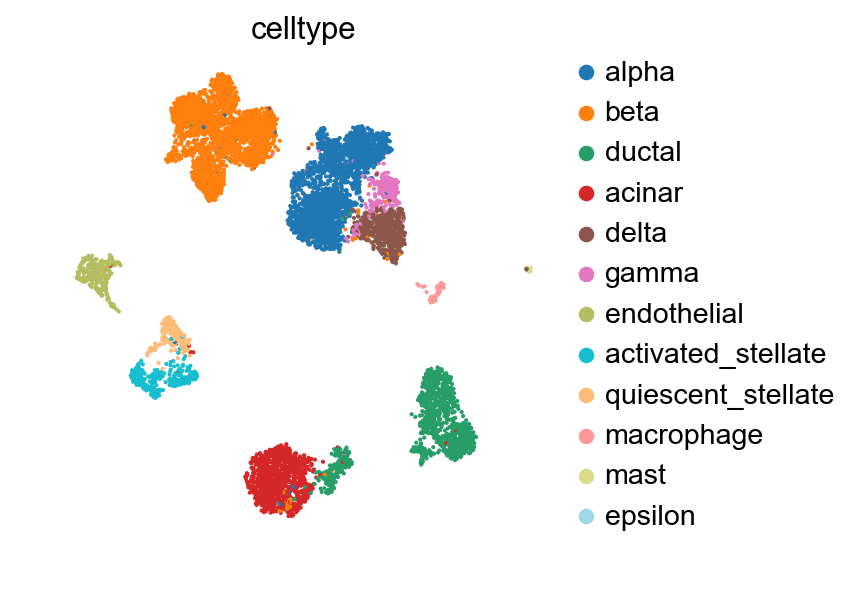

In [29]:
sc.pl.umap(adata_ref, color='celltype')

Iteratively map labels (such as 'celltype') and embeddings (such as 'X_pca' and 'X_umap') from the reference data onto the query batches.

In [30]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ['1', '2', '3']]

In [31]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['celltype_orig'] = adata.obs.celltype  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs='celltype')

... integrating batch 1
running ingest
    finished (0:00:06)
... integrating batch 2
running ingest
    finished (0:00:04)
... integrating batch 3
running ingest
    finished (0:00:01)


Each of the query batches now carries annotation that has been contextualized with `adata_ref`. By concatenating, we can view it together.

In [32]:
adata_concat = adata_ref.concatenate(adatas)

In [33]:
adata_concat.obs.celltype = adata_concat.obs.celltype.astype('category')
adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['celltype_colors'] = adata_ref.uns['celltype_colors']  # fix category coloring

... storing 'celltype_orig' as categorical
... storing 'louvain' as categorical
... storing 'sample' as categorical


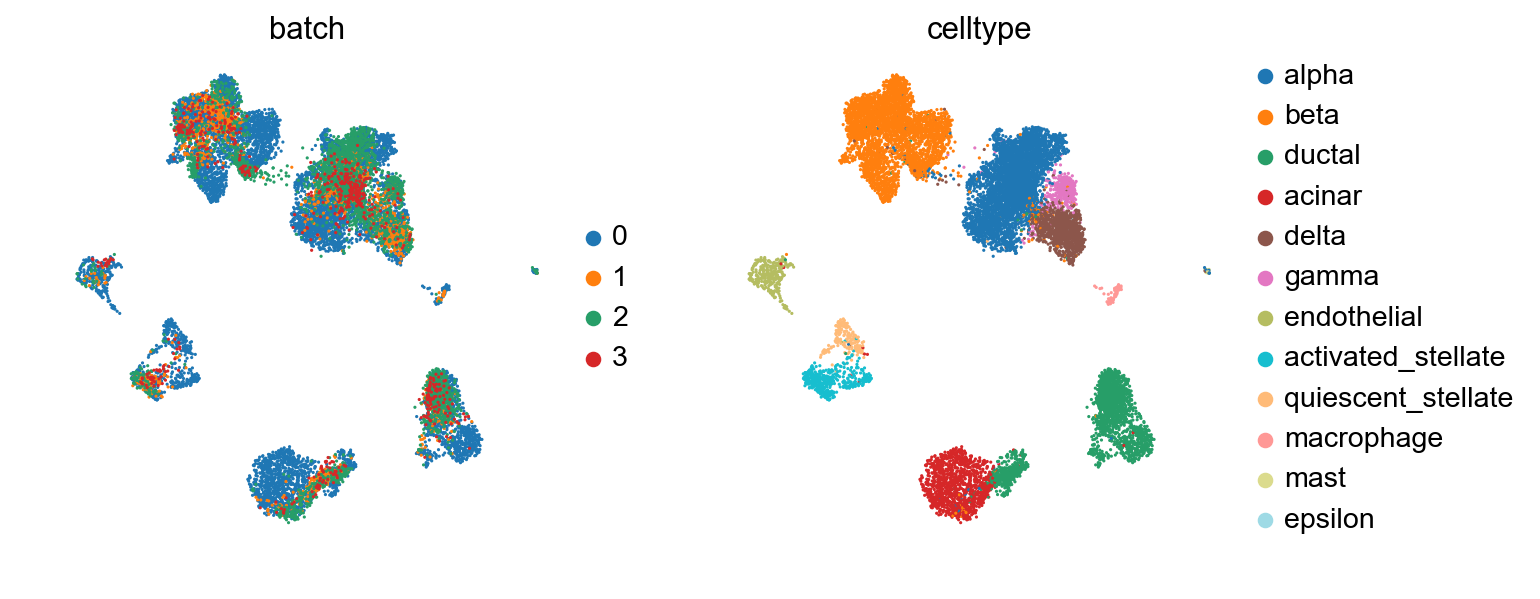

In [34]:
sc.pl.umap(adata_concat, color=['batch', 'celltype'])

Compared to the BBKNN result, this is maintained clusters in a much more pronounced fashion. If one already observed a desired continuous structure (as in the hematopoietic datasets, for instance), `ingest` allows to easily maintain this structure.

### Evaluating consistency

Let us subset the data to the query batches.

In [35]:
adata_query = adata_concat[adata_concat.obs.batch.isin(['1', '2', '3'])]

The following plot is a bit hard to read, hence, move on to confusion matrices below.

/Users/alexwolf/repos/anndata/anndata/_core/anndata.py:1118: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning,


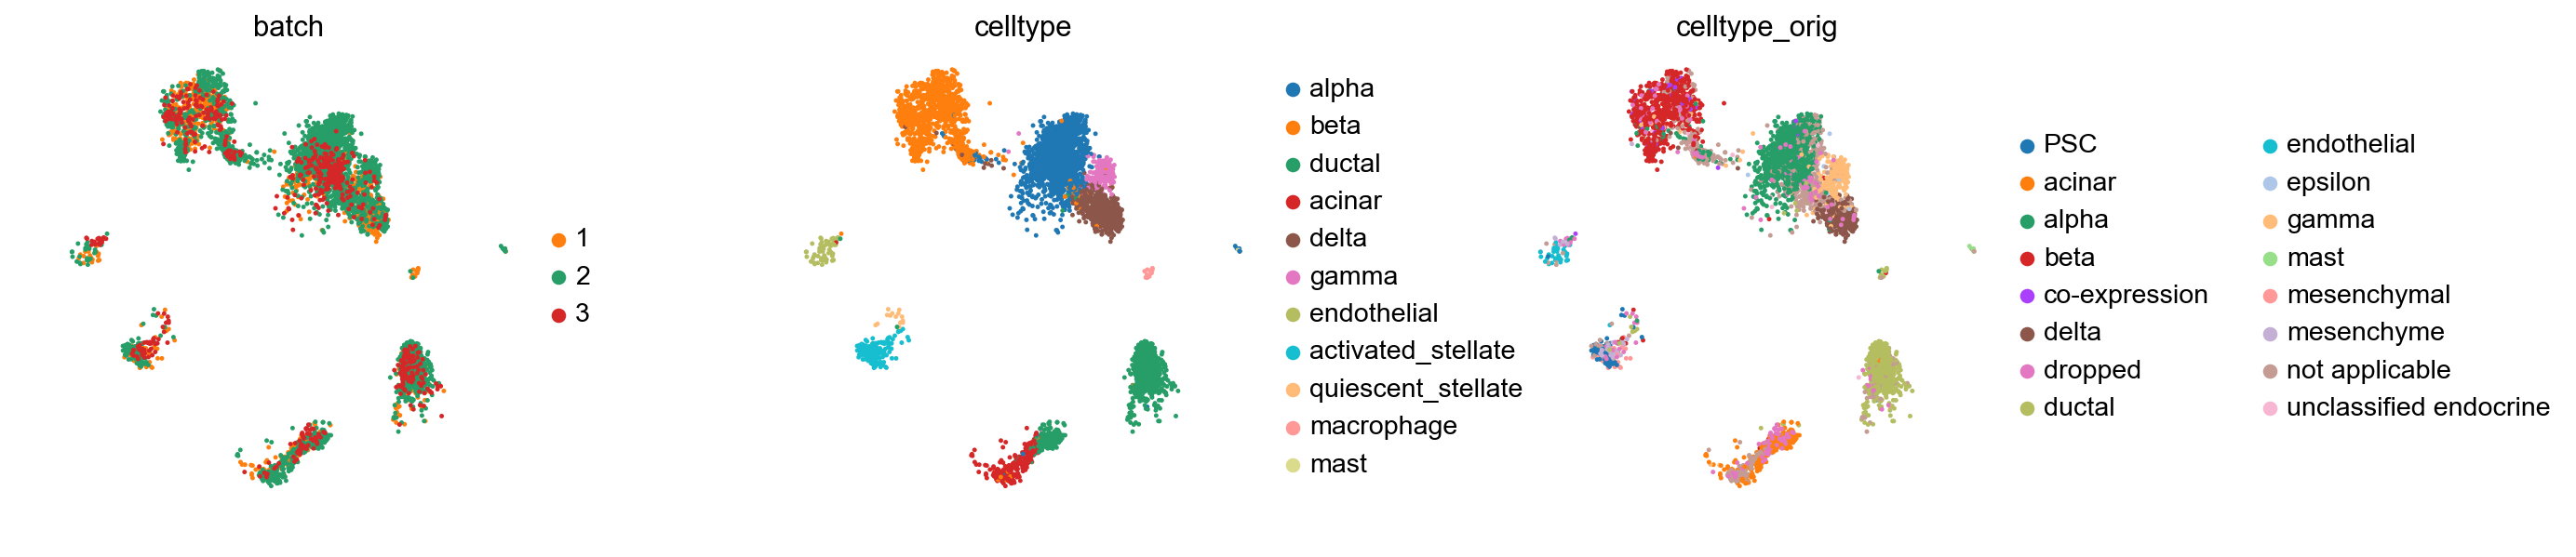

In [36]:
sc.pl.umap(
    adata_query, color=['batch', 'celltype', 'celltype_orig'], wspace=0.4)

#### Cell types conserved across batches

Let us first focus on cell types that are conserved with the reference, to simplify reading of the confusion matrix.

In [37]:
obs_query = adata_query.obs
conserved_categories = obs_query.celltype.cat.categories.intersection(obs_query.celltype_orig.cat.categories)  # intersected categories
obs_query_conserved = obs_query.loc[obs_query.celltype.isin(conserved_categories) & obs_query.celltype_orig.isin(conserved_categories)]  # intersect categories
obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.reorder_categories(obs_query_conserved.celltype.cat.categories, inplace=True)  # fix category ordering

In [38]:
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)

celltype_orig,alpha,beta,ductal,acinar,delta,gamma,endothelial,mast
celltype,,,,,,,,
alpha,1819,3,7,0,1,20,0,5
beta,49,803,3,1,10,26,0,0
ductal,8,5,693,263,0,0,0,0
acinar,1,3,2,145,0,3,0,0
delta,5,4,0,0,305,73,0,0
gamma,1,5,0,0,0,194,0,0
endothelial,2,0,0,0,0,0,36,0
mast,0,0,1,0,0,0,0,2


Overall, the conserved cell types are also mapped as expected. The main exception are some acinar cells in the original annotation that appear as acinar cells. However, already the reference data is observed to feature a cluster of both acinar and ductal cells, which explains the discrepancy, and indicates a potential inconsistency in the initial annotation.

#### All cell types

Let us now move on to look at all cell types.

In [39]:
pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_orig)

celltype_orig,PSC,acinar,alpha,beta,co-expression,delta,dropped,ductal,endothelial,epsilon,gamma,mast,mesenchymal,mesenchyme,not applicable,unclassified endocrine
celltype,,,,,,,,,,,,,,,,
alpha,0,0,1819,3,2,1,33,7,0,3,20,5,0,0,305,11
beta,0,1,49,803,36,10,42,3,0,1,26,0,0,1,522,24
ductal,0,263,8,5,0,0,41,693,0,0,0,0,1,0,106,1
acinar,0,145,1,3,0,0,25,2,0,0,3,0,0,0,86,0
delta,0,0,5,4,1,305,12,0,0,5,73,0,0,0,94,5
gamma,0,0,1,5,0,0,2,0,0,1,194,0,0,0,14,0
endothelial,1,0,2,0,0,0,7,0,36,0,0,0,0,6,7,0
activated_stellate,49,1,1,4,0,0,11,8,0,0,0,0,79,20,17,0
quiescent_stellate,4,0,1,1,0,0,5,1,1,0,0,0,0,0,1,0


We observe that PSC ([pancreatic stellate cells](https://en.wikipedia.org/wiki/Pancreatic_stellate_cell)) cells are in fact just inconsistently annotated and correctly mapped on 'activated_stellate' cells.

Also, it's nice to see that 'mesenchyme' and 'mesenchymal' cells both map onto the same category. However, that category is again 'activated_stellate' and likely incorrect.

### Visualizing distributions across batches

Often, batches correspond to experiments that one wants to compare. Scanpy offers to convenient visualization possibilities for this.

1. a density plot
2. a partial visualization of a subset of categories/groups in an emnbedding

#### Density plot

In [40]:
sc.tl.embedding_density(adata_concat, groupby='batch')

computing density on 'umap'


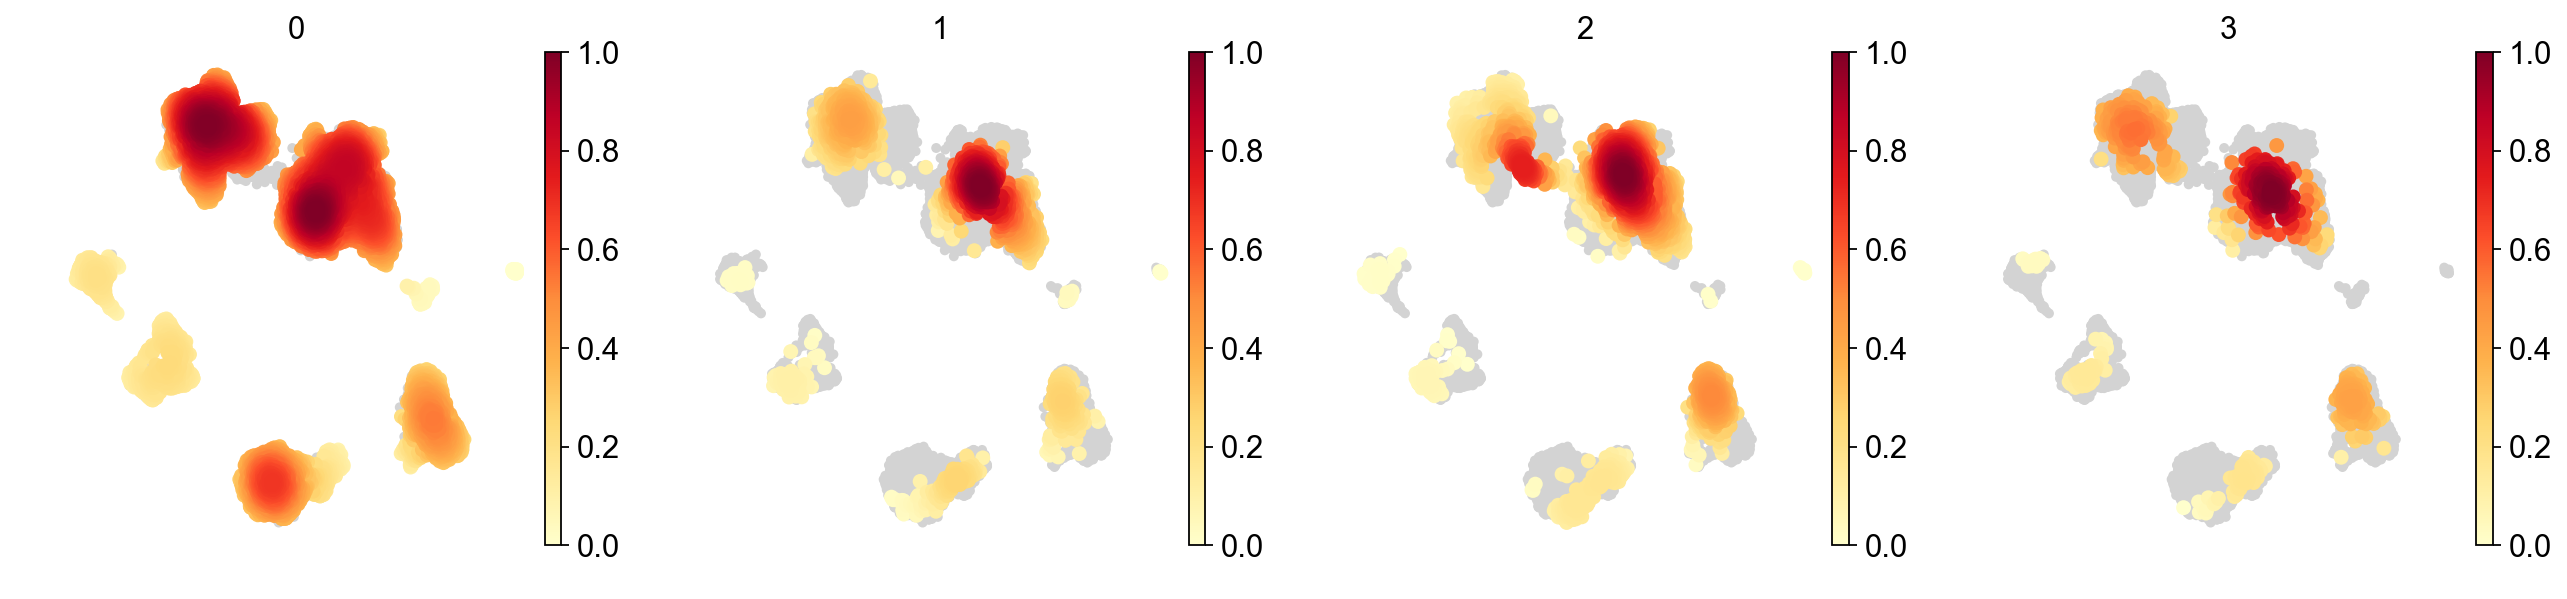

In [41]:
sc.pl.embedding_density(adata_concat, groupby='batch')

#### Partial visualizaton of a subset of groups in embedding

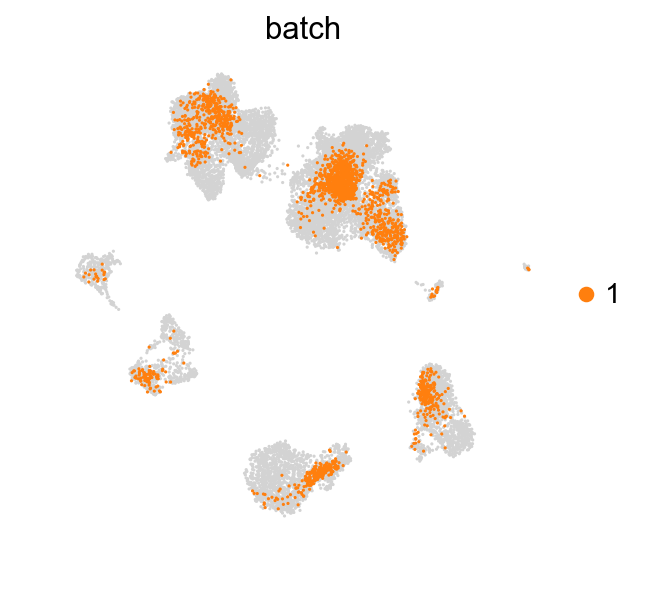

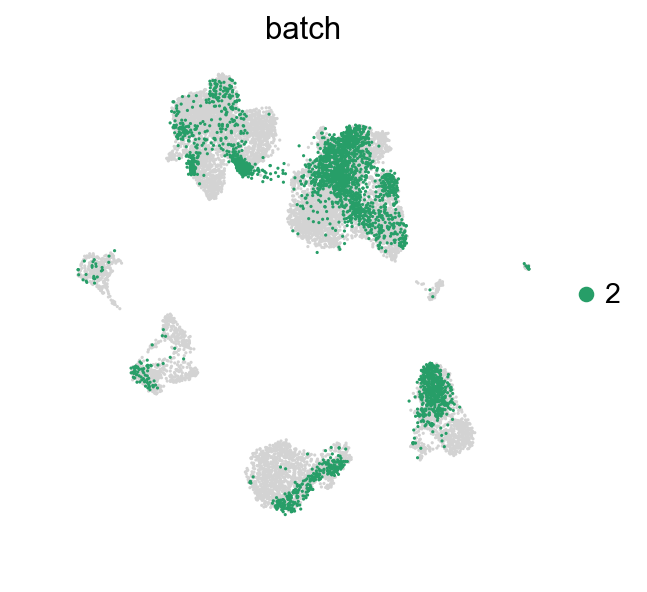

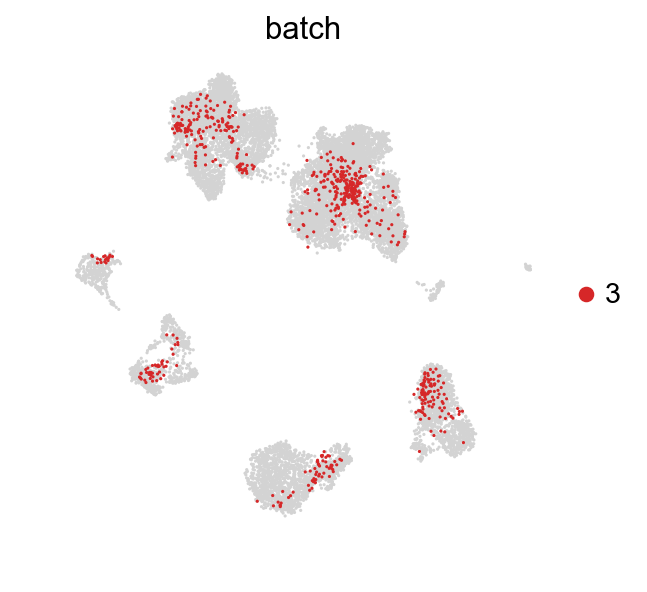

In [42]:
for batch in ['1', '2', '3']:
    sc.pl.umap(adata_concat, color='batch', groups=[batch])